<a href="https://colab.research.google.com/github/suppakrit-w/Final-DeepLearning/blob/main/Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Download and Prepare Data

## Download Dataset

In [3]:
# 1. Install Kaggle API
!pip install -q kaggle

# 2. create folder for kaggle.json
!mkdir -p ~/.kaggle

# 3. get kaggle.json
from google.colab import files
files.upload()

# 4. Move file and set permissions
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 5. Download Dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# 6. Unzip Dataset
!unzip -q skin-cancer-mnist-ham10000.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [01:57<00:00, 181MB/s]
100% 5.20G/5.20G [01:57<00:00, 47.5MB/s]


### Plot distribution of each class

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


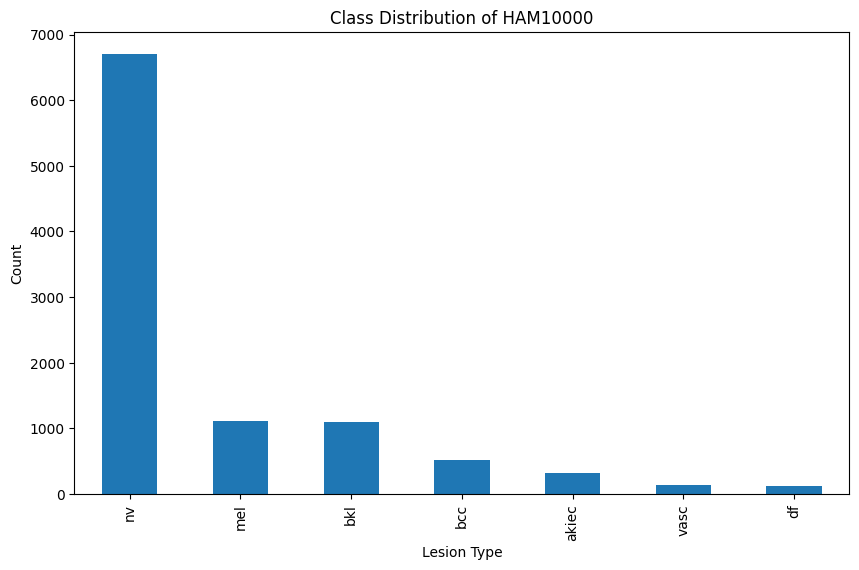

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('HAM10000_metadata.csv')

print(df['dx'].value_counts())

plt.figure(figsize=(10, 6))
df['dx'].value_counts().plot(kind='bar')
plt.title('Class Distribution of HAM10000')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.show()

### Move data into single folder

data_sorted/  
├── train/  
│   ├── nv/  
│   ├── mel/  
│   ├── bcc/  
│   └── ... (all 7 classes)  
└── val/  
    ├── nv/  
    ├── mel/  
    ├── bcc/  
    └── ... (all 7 classes)  

In [7]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
from tqdm.notebook import tqdm

print("Starting image organization script...")

# --- 1. Load Metadata ---
try:
    df = pd.read_csv('HAM10000_metadata.csv')
except FileNotFoundError:
    print("Error: 'HAM10000_metadata.csv' not found.")
    print("Please make sure you have downloaded and unzipped the dataset correctly.")

# --- 2. Create Train/Val Split ---
# We use 'stratify=df['dx']' to ensure both train and val sets
# have the same proportion of classes as the original dataset.
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['dx']
)

print(f"Total images: {len(df)}")
print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(val_df)}")

# --- 3. Define Source and Destination Dirs ---
# (MODIFIED) Define the two source folders
source_dir_1 = 'HAM10000_images_part_1'
source_dir_2 = 'HAM10000_images_part_2'
base_dest_dir = 'data_sorted' # Our new organized folder

# Get all 7 class names
class_names = df['dx'].unique()

# --- 4. Create Directory Structure ---
for split in ['train', 'val']:
    split_dir = os.path.join(base_dest_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for class_name in class_names:
        class_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

print("Directory structure created.")

# --- 5. Function to copy files (MODIFIED) ---
# This function now checks both source directories
def copy_images(dataframe, split_name):
    print(f"\nCopying {split_name} images...")

    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        image_filename = row['image_id'] + '.jpg'

        # Check source_dir_1
        source_path_1 = os.path.join(source_dir_1, image_filename)
        # Check source_dir_2
        source_path_2 = os.path.join(source_dir_2, image_filename)

        # Determine the correct source path
        source_path = None
        if os.path.exists(source_path_1):
            source_path = source_path_1
        elif os.path.exists(source_path_2):
            source_path = source_path_2
        else:
            print(f"Warning: Source file not found for {image_filename}")
            continue # Skip this file

        # Define destination
        dest_path = os.path.join(base_dest_dir, split_name, row['dx'], image_filename)

        # Copy the file
        shutil.copyfile(source_path, dest_path)

# --- 6. Run the copy process ---
copy_images(train_df, 'train')
copy_images(val_df, 'val')

print("\n--- Image organization complete! ---")
print(f"Data is now sorted in '{base_dest_dir}'")

Starting image organization script...
Total images: 10015
Training images: 8012
Validation images: 2003
Directory structure created.

Copying train images...


  0%|          | 0/8012 [00:00<?, ?it/s]


Copying val images...


  0%|          | 0/2003 [00:00<?, ?it/s]


--- Image organization complete! ---
Data is now sorted in 'data_sorted'


# 2. Data pre-processing

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# === Global Constants ===

# --- Hardware ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Data ---
BASE_DIR = 'data_sorted' # โฟลเดอร์ที่จัดเรียงแล้ว
IMAGE_SIZE = 224

# --- Training ---
BATCH_SIZE = 32
EPOCHS = 15
LR = 0.001 # Learning Rate

print(f"Using device: {DEVICE}")

Using device: cuda


In [9]:
# --- Data Pipeline ---

def get_data_loaders(base_dir, batch_size, image_size):
    """
    สร้างและคืนค่า DataLoaders (train, val)
    พร้อม WeightedRandomSampler สำหรับ train_loader
    """

    # --- Transforms (ImageNet Stats) ---
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
    }

    # --- Datasets ---
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')

    train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
    val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

    class_names = train_dataset.classes
    print(f"Classes: {class_names}")

    # --- WeightedRandomSampler (แก้ Imbalance) ---
    print("Setting up WeightedRandomSampler...")
    class_counts = np.bincount(train_dataset.targets)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[train_dataset.targets]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    # --- DataLoaders ---
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, sampler=sampler),
        'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    }

    return dataloaders, class_names, len(train_dataset), len(val_dataset)

# 3. Create Model

In [10]:
# --- Model Factory ---

# Our Custom CNN
class MyCustomCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(MyCustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2), # 112
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2), # 56
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2) # 28
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# --- Model factory ---
def create_model(model_name: str, num_classes: int, lr: float):
    """
    สร้าง Model, Criterion, และ Optimizer
    ตามชื่อโมเดลที่เลือก ('resnet', 'efficientnet', 'custom')
    """
    model = None
    optimizer = None

    # Load pre-trained ResNet 50
    if model_name == 'resnet':
        print("Loading pre-trained ResNet50")
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # Freeze model parameter
        for param in model.parameters():
            param.requires_grad = False # Freeze
        num_ftrs = model.fc.in_features
        # Replace ResNet fc layer
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        optimizer = optim.Adam(model.fc.parameters(), lr=lr)

    # Load pre-trained EfficientNet-B0
    elif model_name == 'efficientnet':
        print("Loading pre-trained EfficientNet-B0")
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        # Freeze model parameter
        for param in model.parameters():
            param.requires_grad = False # Freeze
        num_ftrs = model.classifier[1].in_features
        # Replace EffNet classifier layer
        model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    elif model_name == 'custom':
        print("Initializing Custom CNN (Baseline)")
        model = MyCustomCNN(num_classes=num_classes)
        optimizer = optim.Adam(model.parameters(), lr=lr)

    else:
        raise ValueError(f"Unknown model name: {model_name}. Choose 'resnet', 'efficientnet', or 'custom'.")

    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()

    return model, criterion, optimizer

## 4. Train Model

In [14]:
# --- Train & Evaluate ---

def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs):
    """
    Main Training Loop
    """
    print("\n--- Starting Training ---")

    # Store history for graph plotting
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # -------------------
        #  Training Phase
        # -------------------
        model.train()
        running_loss = 0.0
        correct_train = 0

        for inputs, labels in tqdm(dataloaders['train'], desc="Training"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / dataset_sizes['train']
        epoch_train_acc = correct_train / dataset_sizes['train']

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # -------------------
        #  Validation Phase
        # -------------------
        model.eval()
        val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(dataloaders['val'], desc="Validation"):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)

                val_loss += loss.item() * inputs.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / dataset_sizes['val']
        epoch_val_acc = correct_val / dataset_sizes['val']

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    print("--- Finished Training ---")
    return model, history


def evaluate_model(model, dataloader, device, class_names):
    """
    Evaluate Model on Validation/Test set and print Report
    """
    print("\n--- Final Evaluation ---")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    # Plot confusion matrix using seaborn
    import seaborn as sns
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def plot_history(history, model_name):
    """
    Plot Accuracy and Loss from history
    """
    print(f"\n--- Plotting results for {model_name} ---")
    epochs_range = range(1, EPOCHS + 1)

    plt.figure(figsize=(12, 5))

    # กราฟ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Accuracy ({model_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # กราฟ Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Loss ({model_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.show()

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Setting up WeightedRandomSampler...
Loading pre-trained ResNet50
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 69.1MB/s]



--- Starting Training ---
Epoch 1/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.2246 Acc: 0.5461 | Val Loss: 1.2876 Acc: 0.5342
Epoch 2/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.9281 Acc: 0.6585 | Val Loss: 0.9477 Acc: 0.6326
Epoch 3/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.8131 Acc: 0.7059 | Val Loss: 0.8644 Acc: 0.6595
Epoch 4/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.7707 Acc: 0.7161 | Val Loss: 0.8311 Acc: 0.6915
Epoch 5/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.7185 Acc: 0.7324 | Val Loss: 0.7831 Acc: 0.7054
Epoch 6/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6723 Acc: 0.7466 | Val Loss: 0.6747 Acc: 0.7414
Epoch 7/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6473 Acc: 0.7620 | Val Loss: 0.8368 Acc: 0.6810
Epoch 8/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6301 Acc: 0.7649 | Val Loss: 0.6734 Acc: 0.7534
Epoch 9/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6059 Acc: 0.7698 | Val Loss: 0.7231 Acc: 0.7099
Epoch 10/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6025 Acc: 0.7746 | Val Loss: 0.7528 Acc: 0.7099
Epoch 11/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5889 Acc: 0.7818 | Val Loss: 0.7710 Acc: 0.7039
Epoch 12/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5756 Acc: 0.7832 | Val Loss: 0.6337 Acc: 0.7604
Epoch 13/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5600 Acc: 0.7927 | Val Loss: 0.7483 Acc: 0.7099
Epoch 14/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5500 Acc: 0.7951 | Val Loss: 0.6823 Acc: 0.7539
Epoch 15/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5231 Acc: 0.8075 | Val Loss: 0.6637 Acc: 0.7439
--- Finished Training ---

--- Plotting results for resnet ---


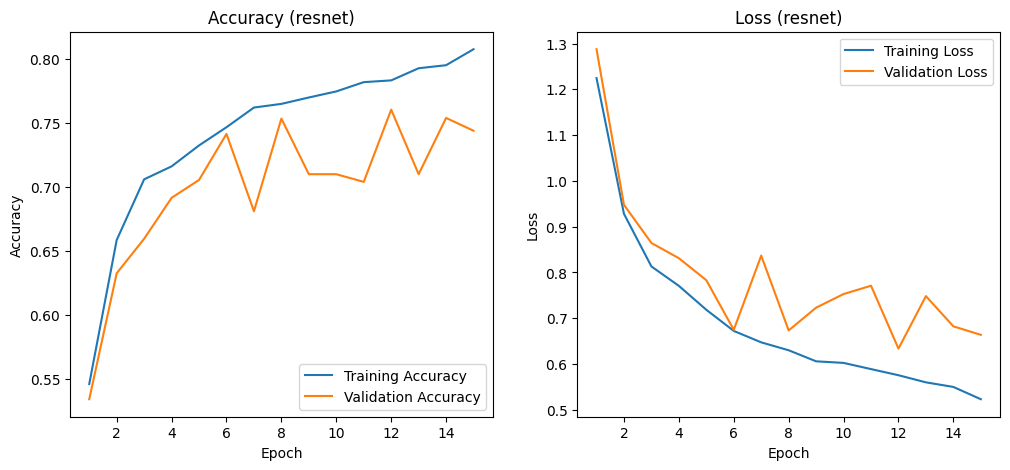


--- Final Evaluation ---

Classification Report:
              precision    recall  f1-score   support

       akiec     0.4153    0.7538    0.5355        65
         bcc     0.5180    0.6990    0.5950       103
         bkl     0.5172    0.6818    0.5882       220
          df     0.4375    0.6087    0.5091        23
         mel     0.4416    0.5426    0.4869       223
          nv     0.9507    0.7912    0.8637      1341
        vasc     0.6765    0.8214    0.7419        28

    accuracy                         0.7439      2003
   macro avg     0.5653    0.6998    0.6172      2003
weighted avg     0.7971    0.7439    0.7612      2003


Confusion Matrix:
[[  49    5    6    1    4    0    0]
 [  11   72   11    1    3    5    0]
 [  23   11  150    1   18   17    0]
 [   1    1    3   14    2    2    0]
 [  16   11   39    4  121   31    1]
 [  18   36   80   11  125 1061   10]
 [   0    3    1    0    1    0   23]]
Model saved to ham10000_resnet.pth


In [12]:
# --- Main Execution ---

# -------------------------------------------------------------------
# Select Model: 'resnet', 'efficientnet', 'custom'
MODEL_NAME_TO_RUN = 'resnet'
# -------------------------------------------------------------------

# 1. Load Dataloader
dataloaders, class_names, train_size, val_size = get_data_loaders(
    base_dir=BASE_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)
dataset_sizes = {'train': train_size, 'val': val_size}

# 2. Create Model
model, criterion, optimizer = create_model(
    model_name=MODEL_NAME_TO_RUN,
    num_classes=len(class_names),
    lr=LR
)

# 3. Train
model, history = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    num_epochs=EPOCHS
)

# 4. Plot
plot_history(history, MODEL_NAME_TO_RUN)

# 5. Evaluate
evaluate_model(model, dataloaders['val'], DEVICE, class_names)

# 6. Save model
torch.save(model.state_dict(), f"ham10000_{MODEL_NAME_TO_RUN}.pth")
print(f"Model saved to ham10000_{MODEL_NAME_TO_RUN}.pth")


--- Final Evaluation ---

Classification Report:
              precision    recall  f1-score   support

       akiec     0.4153    0.7538    0.5355        65
         bcc     0.5180    0.6990    0.5950       103
         bkl     0.5172    0.6818    0.5882       220
          df     0.4375    0.6087    0.5091        23
         mel     0.4416    0.5426    0.4869       223
          nv     0.9507    0.7912    0.8637      1341
        vasc     0.6765    0.8214    0.7419        28

    accuracy                         0.7439      2003
   macro avg     0.5653    0.6998    0.6172      2003
weighted avg     0.7971    0.7439    0.7612      2003


Confusion Matrix:
[[  49    5    6    1    4    0    0]
 [  11   72   11    1    3    5    0]
 [  23   11  150    1   18   17    0]
 [   1    1    3   14    2    2    0]
 [  16   11   39    4  121   31    1]
 [  18   36   80   11  125 1061   10]
 [   0    3    1    0    1    0   23]]


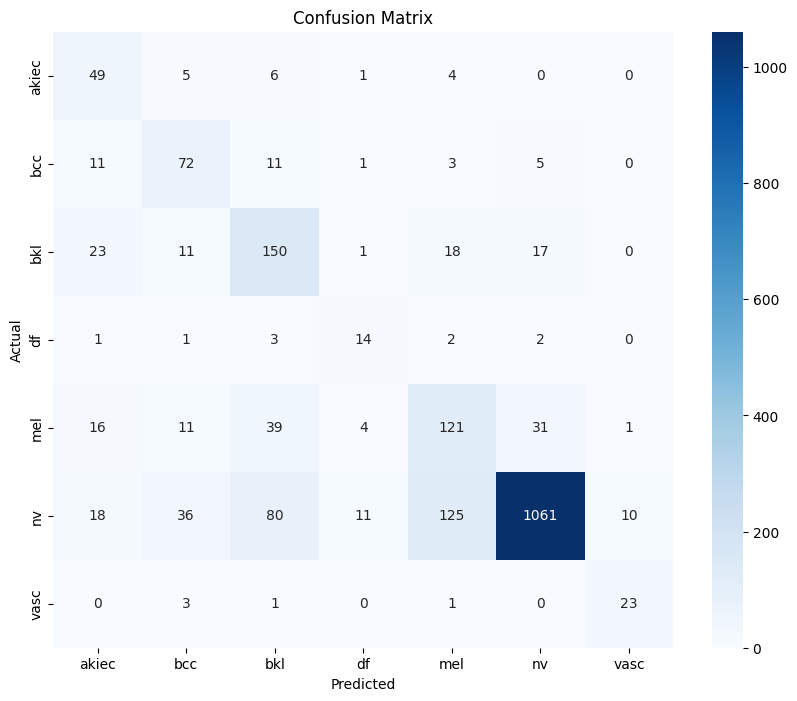

In [15]:
evaluate_model(model, dataloaders['val'], DEVICE, class_names)

## Eff-Net

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Setting up WeightedRandomSampler...
Loading pre-trained EfficientNet-B0
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 124MB/s]



--- Starting Training ---
Epoch 1/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.0862 Acc: 0.6046 | Val Loss: 1.1054 Acc: 0.5836
Epoch 2/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.8547 Acc: 0.6875 | Val Loss: 1.0390 Acc: 0.6126
Epoch 3/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.7553 Acc: 0.7225 | Val Loss: 0.9073 Acc: 0.6335
Epoch 4/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.7037 Acc: 0.7330 | Val Loss: 0.9017 Acc: 0.6580
Epoch 5/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6418 Acc: 0.7640 | Val Loss: 0.8462 Acc: 0.6590
Epoch 6/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6353 Acc: 0.7697 | Val Loss: 0.8328 Acc: 0.6570
Epoch 7/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6027 Acc: 0.7763 | Val Loss: 0.7723 Acc: 0.6940
Epoch 8/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5865 Acc: 0.7828 | Val Loss: 0.7248 Acc: 0.7239
Epoch 9/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5645 Acc: 0.7964 | Val Loss: 0.6494 Acc: 0.7584
Epoch 10/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5544 Acc: 0.7929 | Val Loss: 0.8364 Acc: 0.6770
Epoch 11/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5375 Acc: 0.7987 | Val Loss: 0.7385 Acc: 0.7199
Epoch 12/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5168 Acc: 0.8119 | Val Loss: 0.7814 Acc: 0.7049
Epoch 13/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5109 Acc: 0.8040 | Val Loss: 0.8244 Acc: 0.6845
Epoch 14/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5125 Acc: 0.8122 | Val Loss: 0.7801 Acc: 0.6990
Epoch 15/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.4879 Acc: 0.8184 | Val Loss: 0.7490 Acc: 0.7259
--- Finished Training ---

--- Plotting results for efficientnet ---


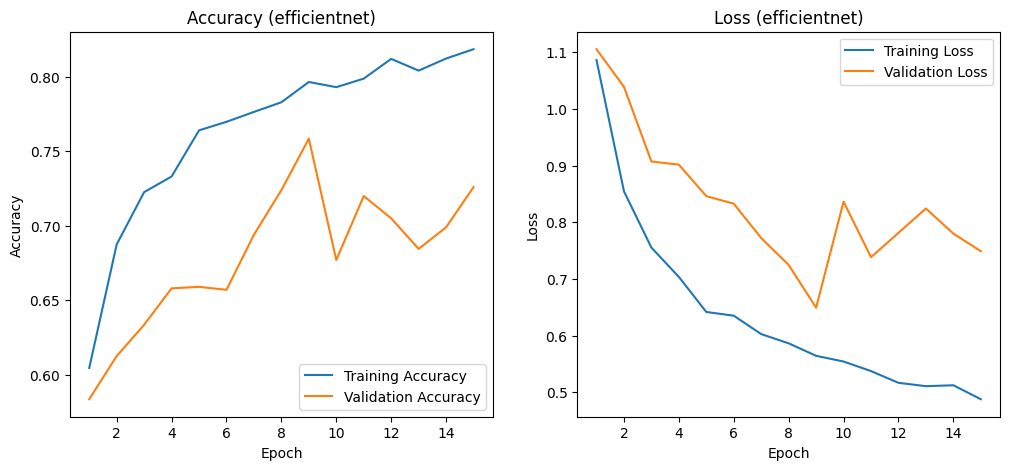


--- Final Evaluation ---

Classification Report:
              precision    recall  f1-score   support

       akiec     0.6197    0.6769    0.6471        65
         bcc     0.5455    0.6990    0.6128       103
         bkl     0.4368    0.7545    0.5533       220
          df     0.6667    0.6957    0.6809        23
         mel     0.4144    0.5426    0.4699       223
          nv     0.9494    0.7554    0.8414      1341
        vasc     0.5946    0.7857    0.6769        28

    accuracy                         0.7259      2003
   macro avg     0.6039    0.7014    0.6403      2003
weighted avg     0.7939    0.7259    0.7462      2003


Confusion Matrix:
[[  44    7    9    1    4    0    0]
 [   4   72   15    0    7    4    1]
 [   9    9  166    1   18   16    1]
 [   0    3    3   16    1    0    0]
 [   5    9   56    1  121   31    0]
 [   8   31  131    5  140 1013   13]
 [   1    1    0    0    1    3   22]]


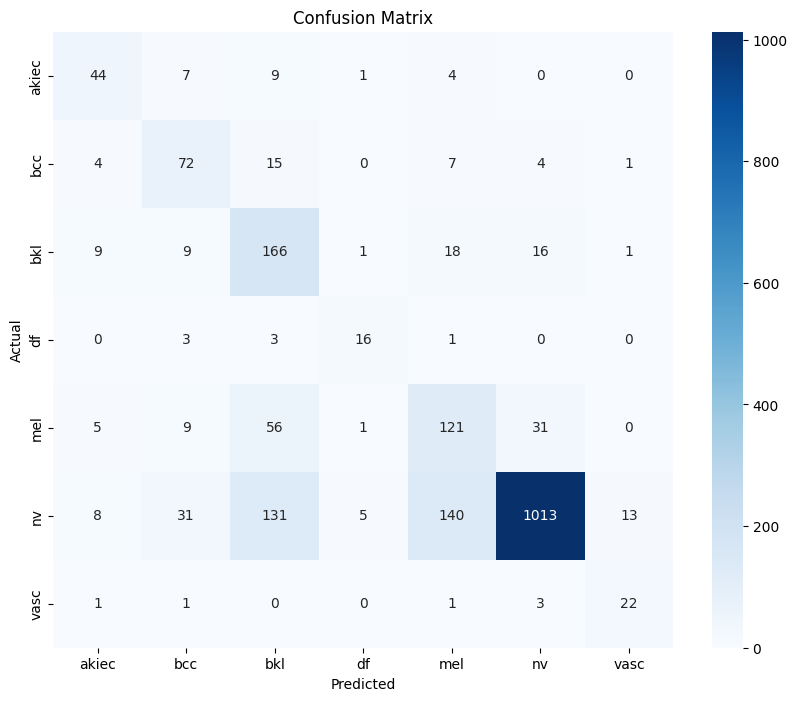

Model saved to ham10000_efficientnet.pth


In [16]:
# --- Main Execution ---

# -------------------------------------------------------------------
# Select Model: 'resnet', 'efficientnet', 'custom'
MODEL_NAME_TO_RUN = 'efficientnet'
# -------------------------------------------------------------------

# 1. Load Dataloader
dataloaders, class_names, train_size, val_size = get_data_loaders(
    base_dir=BASE_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)
dataset_sizes = {'train': train_size, 'val': val_size}

# 2. Create Model
model, criterion, optimizer = create_model(
    model_name=MODEL_NAME_TO_RUN,
    num_classes=len(class_names),
    lr=LR
)

# 3. Train
model, history = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    num_epochs=EPOCHS
)

# 4. Plot
plot_history(history, MODEL_NAME_TO_RUN)

# 5. Evaluate
evaluate_model(model, dataloaders['val'], DEVICE, class_names)

# 6. Save Model
torch.save(model.state_dict(), f"ham10000_{MODEL_NAME_TO_RUN}.pth")
print(f"Model saved to ham10000_{MODEL_NAME_TO_RUN}.pth")

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Setting up WeightedRandomSampler...
Initializing Custom CNN (Baseline)

--- Starting Training ---
Epoch 1/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.5961 Acc: 0.3852 | Val Loss: 1.2360 Acc: 0.4883
Epoch 2/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.2796 Acc: 0.5001 | Val Loss: 1.1639 Acc: 0.5232
Epoch 3/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.1297 Acc: 0.5688 | Val Loss: 1.1532 Acc: 0.5247
Epoch 4/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.0220 Acc: 0.6166 | Val Loss: 0.9765 Acc: 0.5956
Epoch 5/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.9290 Acc: 0.6568 | Val Loss: 0.9374 Acc: 0.6326
Epoch 6/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.8538 Acc: 0.6829 | Val Loss: 0.9217 Acc: 0.6296
Epoch 7/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.7665 Acc: 0.7101 | Val Loss: 1.0393 Acc: 0.6021
Epoch 8/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.7120 Acc: 0.7369 | Val Loss: 0.9899 Acc: 0.6236
Epoch 9/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6694 Acc: 0.7517 | Val Loss: 0.9197 Acc: 0.6321
Epoch 10/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6373 Acc: 0.7610 | Val Loss: 1.0310 Acc: 0.6206
Epoch 11/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5856 Acc: 0.7878 | Val Loss: 0.9790 Acc: 0.6530
Epoch 12/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5717 Acc: 0.7848 | Val Loss: 0.9337 Acc: 0.6825
Epoch 13/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5432 Acc: 0.7947 | Val Loss: 0.8755 Acc: 0.6820
Epoch 14/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.4882 Acc: 0.8160 | Val Loss: 1.0142 Acc: 0.6375
Epoch 15/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.4914 Acc: 0.8195 | Val Loss: 0.9988 Acc: 0.6425
--- Finished Training ---

--- Plotting results for custom ---


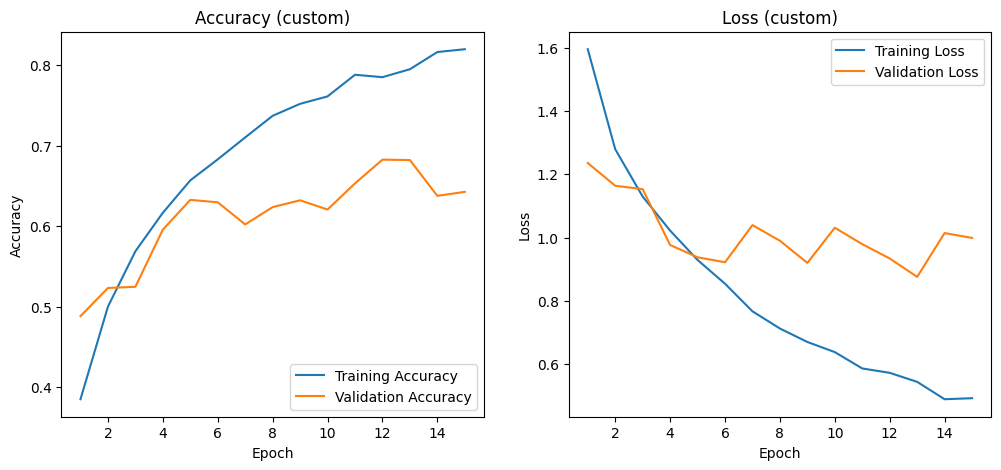


--- Final Evaluation ---

Classification Report:
              precision    recall  f1-score   support

       akiec     0.3182    0.5385    0.4000        65
         bcc     0.4907    0.5146    0.5024       103
         bkl     0.3932    0.5273    0.4505       220
          df     0.2708    0.5652    0.3662        23
         mel     0.3190    0.6323    0.4241       223
          nv     0.9401    0.6786    0.7882      1341
        vasc     0.5938    0.6786    0.6333        28

    accuracy                         0.6425      2003
   macro avg     0.4751    0.5907    0.5092      2003
weighted avg     0.7551    0.6425    0.6763      2003


Confusion Matrix:
[[ 35   8  11   0   9   2   0]
 [ 17  53  15   6   7   5   0]
 [ 27  12 116   5  32  27   1]
 [  3   3   2  13   1   1   0]
 [ 12   2  38   6 141  21   3]
 [ 13  28 113  18 250 910   9]
 [  3   2   0   0   2   2  19]]


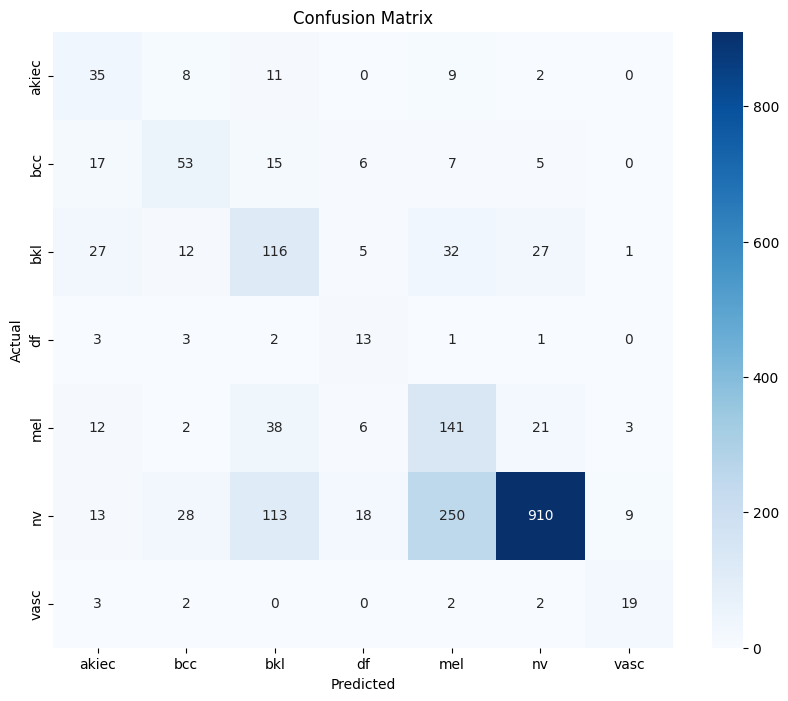

Model saved to ham10000_custom.pth


In [17]:
# --- Main Execution ---

# -------------------------------------------------------------------
# Select Model: 'resnet', 'efficientnet', 'custom'
MODEL_NAME_TO_RUN = 'custom'
# -------------------------------------------------------------------

# 1. Load Dataloader
dataloaders, class_names, train_size, val_size = get_data_loaders(
    base_dir=BASE_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)
dataset_sizes = {'train': train_size, 'val': val_size}

# 2. Create Model
model, criterion, optimizer = create_model(
    model_name=MODEL_NAME_TO_RUN,
    num_classes=len(class_names),
    lr=LR
)

# 3. Train
model, history = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    num_epochs=EPOCHS
)

# 4. Plot
plot_history(history, MODEL_NAME_TO_RUN)

# 5. Evaluate
evaluate_model(model, dataloaders['val'], DEVICE, class_names)

# 6. Save Model
torch.save(model.state_dict(), f"ham10000_{MODEL_NAME_TO_RUN}.pth")
print(f"Model saved to ham10000_{MODEL_NAME_TO_RUN}.pth")